---
title: "Solvers"
format:
  html:
    embed-resources: true
    code-fold: true
    toc: true
---

## Notes

From the root directory, run "pip install -e ." in your current environment to download the package with the environment in order to wrap around gym and rllib. The information of the download is in setup.py.

## Versions and Dependencies

In [1]:
import ray
print(ray.__version__)

2.39.0


In [2]:
import subprocess

# Run the pip list command and print the output
installed_packages = subprocess.run(["pip", "list"], capture_output=True, text=True)
print(installed_packages.stdout)

Package                   Version     Editable project location
------------------------- ----------- ---------------------------------
absl-py                   2.1.0
aiosignal                 1.3.2
appnope                   0.1.4
asttokens                 3.0.0
attrs                     25.1.0
certifi                   2025.1.31
charset-normalizer        3.4.1
click                     8.1.8
cloudpickle               3.1.1
cmake                     3.31.4
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.12
decorator                 5.1.1
dm-tree                   0.1.9
exceptiongroup            1.2.2
executing                 2.1.0
Farama-Notifications      0.0.4
filelock                  3.17.0
fonttools                 4.56.0
frozenlist                1.5.0
fsspec                    2025.2.0
geosearch_package         0.1.0
gymnasium                 1.0.0
idna                      3.10
importlib_metadata  

## Libraries

In [3]:
import ray
from gymnasium.envs.registration import register
import gymnasium as gym
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.sac import SACConfig
from ray.rllib.algorithms.dqn import DQNConfig
import numpy as np
from ray import tune
from ray.rllib.algorithms.appo import APPOConfig
import matplotlib
import matplotlib.pyplot as plt
import torch
import pygame
from ray.rllib.models.torch.torch_action_dist import TorchCategorical
import os

In [4]:
# set up matplotlib interactive mode
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

In [5]:
from lunabot.geosearch import GeosearchEnv, Utils

## Load Environment

In [6]:
register(
    id="GeosearchEnv-v0",
    entry_point="geosearch_package.geosearch:GeosearchEnv",
)
env = GeosearchEnv()
#env = gym.make("GeosearchEnv-v0")
obs, info = env.reset()
print("Observation:", obs)

Observation: {'ring_heights': array([0.3475219 , 0.34653082, 0.37377986, 0.41023636, 0.43164885,
       0.31619325, 0.3241645 , 0.3524171 , 0.38347077, 0.39880082,
       0.303915  , 0.32174224, 0.34934685, 0.369918  , 0.37209156,
       0.30269292, 0.32854652, 0.35645252, 0.36833957, 0.35756597,
       0.30586004, 0.3354572 , 0.3643261 , 0.3721254 , 0.35302848],
      dtype=float32), 'battery': array([1.], dtype=float32), 'position': array([0.47368422, 0.47368422], dtype=float32), 'sunlight': array([0.], dtype=float32), 'dust': array([0.8800087], dtype=float32), 'water_map': array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
  

## Helper functions to visualize training

In [7]:
def plot_metrics(rewards, lengths):
    fig = plt.figure(1, figsize=(16, 8))
    plt.clf()

    # plt.subplots(ncols=2, figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.set_title('Mean Rewards')
    ax1.set_xlabel('Evaluation Interval')
    ax1.set_ylabel('Mean Reward')
    ax1.plot(rewards)

    ax2.set_title('Mean Episode Length')
    ax2.set_xlabel('Evaluation Interval')
    ax2.set_ylabel('Episode Length')
    ax2.plot(lengths)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [8]:
# Define a generic policy wrapper class that works with all RLlib algorithms
class RLlibPolicyWrapper:
    def __init__(self, algo):
        self.algo = algo
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def process_state(self, state):
        # Convert dictionary observation to array
        state_array = np.concatenate([
            state['height'],
            state['battery'],
            state['position'],
            state['sunlight'],
            state['dust'],
            state['water_prob'],
            state['gold_prob']
        ])
        return state_array
        
    def get_action(self, state):
        # Get action from policy
        action = self.algo.compute_single_action(
            observation=state,
            explore=False  # Don't use exploration during visualization
        )
        return action

def visualize_policy(env, algo, algo_name="Algorithm", episodes=5, max_steps=50, save_gif=True, gif_dir="policy_gifs"):
    """
    Generic function to visualize any RLlib algorithm's policy.
    
    Args:
        env: The environment instance
        algo: The RLlib algorithm instance (PPO, SAC, DQN, or APPO)
        algo_name: Name of the algorithm for the output filename
        episodes: Number of episodes to run
        max_steps: Maximum steps per episode
        save_gif: Whether to save the visualization as a GIF
        gif_dir: Directory to save the GIFs (default: "policy_gifs")
    """
    try:
        # Initialize Pygame first
        pygame.init()
        
        # Create policy wrapper
        policy_wrapper = RLlibPolicyWrapper(algo)
        
        # Initialize visualization
        if env.render_mode != 'human':
            env.render_mode = 'human'
        env._init_render()
        
        frames = []
        total_reward = 0
        
        # Create directory for GIFs if it doesn't exist
        if save_gif:
            os.makedirs(gif_dir, exist_ok=True)
            gif_path = os.path.join(gif_dir, f"{algo_name.lower()}_policy.gif")
            print(f"GIF will be saved to: {gif_path}")
        
        for episode in range(episodes):
            state, info = env.reset()
            episode_reward = 0
            terminated = False
            steps = 0
            
            while not terminated and steps < max_steps:
                # Handle Pygame events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        raise KeyboardInterrupt
                
                # Render current state
                env.render()
                if save_gif:
                    frame = pygame.surfarray.array3d(env.screen)
                    frames.append(np.transpose(frame, (1, 0, 2)))
                
                # Get action from policy
                action = policy_wrapper.get_action(state)
                
                # Take action in environment
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                episode_reward += reward
                state = next_state
                steps += 1
                
                # Add small delay for visualization
                pygame.time.wait(66)  # ~15 FPS
                
            total_reward += episode_reward
            print(f"Episode {episode + 1} finished with reward: {episode_reward:.2f}")
        
        if save_gif and frames:
            Utils.create_gif(frames, filename=gif_path, duration=66)
            print(f"GIF saved successfully to {gif_path}")
        
        avg_reward = total_reward / episodes
        print(f"Average reward over {episodes} episodes: {avg_reward:.2f}")

    except KeyboardInterrupt:
        print("\nVisualization interrupted by user")
    
    except Exception as e:
        print(f"An error occurred during visualization: {str(e)}")
    
    finally:
        # Ensure proper cleanup
        if hasattr(env, 'close'):
            env.close()
        
        # Additional Pygame cleanup
        pygame.quit()
        print("Visualization completed and resources cleaned up")

## SAC

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # for binary_cross_entropy, etc.
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models import ModelCatalog


# -------------------------------------------------------------------
# ResidualBlock and SkipConnection
# -------------------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + residual)


class SkipConnection(nn.Module):
    """
    Simple skip: x -> Layer -> ReLU -> + x -> out
    """
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.layer(x)
        out = self.relu(out)
        return out + x


# -------------------------------------------------------------------
# EnhancedModelNoPlateau with optional auxiliary loss
# -------------------------------------------------------------------
class EnhancedModelNoPlateau(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name, **kwargs):
        nn.Module.__init__(self)
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        
        # Change the first convolution to expect 2 input channels:
        self.conv_net = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=5, padding=2),  # now 2 channels
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            
            # Adaptive pool to unify size => [B, 128, 4, 4]
            nn.AdaptiveAvgPool2d((4, 4)),
        )

        # 2) MLP for non-image features: ring_heights=25, battery=1, pos=2, sun=1, dust=1 => total=30
        self.mlp = nn.Sequential(
            nn.Linear(30, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            SkipConnection(nn.Linear(256, 256)),  # skip block
            nn.Linear(256, 128),
            nn.ReLU(inplace=True)
        )

        # Combined size: conv_net output (~2048) + mlp output (128) = 2176
        self.trunk = nn.Sequential(
        nn.Linear(2176, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        )


        # Final policy head for the environment's discrete actions
        self.policy_head = nn.Linear(256, num_outputs)

        # Optional value function head (used by RLlib)
        self.value_head = nn.Linear(256, 1)

        # Auxiliary head for water presence (predict 0/1)
        self.aux_head = nn.Linear(256, 1)

        # Store trunk outputs for use in value_function/forward_train
        self._shared_embedding = None

    def forward(self, input_dict, state, seq_lens):
        """
        Normal forward pass for RLlib. Returns policy logits.
        """
        obs = input_dict["obs"]

        # Process the water map (2-channel: water probabilities and agent mask)
        water_map = obs["water_map"].float()  # shape [B, 2, grid_height, grid_width]
        conv_feat = self.conv_net(water_map)   # shape [B, 128, 4, 4]
        conv_flat = conv_feat.view(conv_feat.size(0), -1)  # flatten to [B, 2048]

        # Process non-image features: ring_heights, battery, position, sunlight, dust (total 30 dims)
        non_image = torch.cat([
            obs["ring_heights"].float(),
            obs["battery"].float(),
            obs["position"].float(),
            obs["sunlight"].float(),
            obs["dust"].float()
        ], dim=1)  # shape [B, 30]
        mlp_out = self.mlp(non_image)  # shape [B, 128]

        # Combine the CNN features and non-image features
        combined_in = torch.cat([conv_flat, mlp_out], dim=1)  # shape [B, 2048+128=2176]
        trunk_out = self.trunk(combined_in)  # shape [B, 512]
        self._shared_embedding = trunk_out

        # Produce final policy logits
        logits = self.policy_head(trunk_out)  # shape [B, num_outputs]
        return logits, state

    def forward_train(self, input_dict, state, seq_lens):
        """
        Same as forward(), plus compute an auxiliary loss if "water_label" is present.
        """
        logits, state_out = self.forward(input_dict, state, seq_lens)

        if "water_label" in input_dict:
            label = input_dict["water_label"].float()  # shape [B] or [B, 1]
            p_pred = torch.sigmoid(self.aux_head(self._shared_embedding))  # shape [B, 1]
            if label.dim() == 1:
                label = label.unsqueeze(-1)
            aux_loss = F.binary_cross_entropy(p_pred, label)
            self._aux_loss = aux_loss
        else:
            self._aux_loss = torch.tensor(0.0, device=logits.device)

        return logits, state_out

    def loss(self, model_out, dist_class, train_batch):
        """
        Let RLlib compute its normal RL loss, then add our auxiliary loss.
        """
        base_loss = super().loss(model_out, dist_class, train_batch)
        return base_loss + 0.1 * self._aux_loss

    def value_function(self):
        """
        Used by some RLlib algorithms to get a V(s) or baseline.
        """
        if self._shared_embedding is None:
            return torch.zeros(1)
        return self.value_head(self._shared_embedding).squeeze(-1)



# Register the custom model for usage in your RLlib config
ModelCatalog.register_custom_model(
    "custom_sac_model",
    EnhancedModelNoPlateau
)

import numpy as np
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.policy.sample_batch import SampleBatch

from ray.rllib.algorithms.callbacks import DefaultCallbacks
import numpy as np

class WaterLabelCallback(DefaultCallbacks):
    def on_postprocess_trajectory(
        self,
        *,
        worker,
        episode,
        agent_id,
        policy_id,
        policies,
        postprocessed_batch,
        original_batches,
        **kwargs
    ):
        n = postprocessed_batch.count
        water_labels = np.zeros(shape=(n,), dtype=np.float32)

        # The env info at each step is in postprocessed_batch["infos"]
        if "infos" in postprocessed_batch:
            for i in range(n):
                info_i = postprocessed_batch["infos"][i]
                # Mark water_labels[i] = 1.0 if "is_water_here" was True
                if info_i is not None and info_i.get("is_water_here", False):
                    water_labels[i] = 1.0

        # Attach to the batch so your model can access it in forward_train()
        postprocessed_batch["water_label"] = water_labels

### Ray Instance

In [ ]:
from ray.rllib.algorithms.sac import SACConfig
import numpy as np

# ======================
# Updated SAC Configuration
# for a 15x15 Grid Environment
# ======================

config = SACConfig().callbacks(WaterLabelCallback) 
config.framework_str = "torch"
config.env = GeosearchEnv

# 2) Training settings
config.training(
    # Use your custom model (with residual blocks, skip connections, etc.).
    policy_model_config={
        "custom_model": "custom_sac_model",    # The enhanced model you registered
        "custom_action_dist": "categorical",
    },
    # q_model_config={
    #     "fcnet_hiddens": [512, 512, 256],
    #     "fcnet_activation": "swish",
    # },
    q_model_config={
    "fcnet_hiddens": [512, 512, 256],
    "fcnet_activation": "swish",
    },
    lr=3e-4,                # Larger than your old 5e-5 for faster learning
    tau=0.005,
    initial_alpha=0.2,      # Entropy coefficient
    target_entropy="auto",
    n_step=3,               # Multi-step returns
    train_batch_size=512,   # Reduced batch size for smaller environment
    # Standard ReplayBuffer with capacity reduced for smaller state space
    replay_buffer_config={
        "type": "ReplayBuffer",
        "capacity": 500000,  # Could reduce further if memory is limited
        "alpha": 0.6,  # Prioritization strength
        "beta": 0.4
    }
)

# 3) Environment interaction & rollout
config.rollout_fragment_length = 200
config.num_workers = 8                 # Parallel workers; can reduce if on smaller machine
config.evaluation_num_workers = 4
config.evaluation_interval = 50
config.evaluation_duration = 30

# 4) Discount, exploration
config.gamma = 0.99
config.exploration_config = {
    "type": "EpsilonGreedy",
    "initial_epsilon": 1.0,       # Start very high => strong exploration
    "final_epsilon": 0.05,        # Decay to 0.05
    "epsilon_timesteps": 300000,   # Decay over 20k timesteps (tune as needed)
}

# 5) Discrete SAC enablement (experimental)
config._enable_discrete_sac = True
# For RLlib versions 2.2+, you may need this if you're not using the new RLModule API:
config.api_stack(
    enable_rl_module_and_learner=False,
    enable_env_runner_and_connector_v2=False
)

# 6) Build the final algorithm
algo = config.build()


2025-02-13 20:29:28,384	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:567: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interfa

(RolloutWorker pid=77481) [W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


### Training

In [ ]:
rewards = []
lengths = []

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
2025-02-13 20:29:37,561	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!



Iteration 50/9000
Time elapsed: 0.02 hours
Current reward: 7244.35
Best reward so far: 7244.35


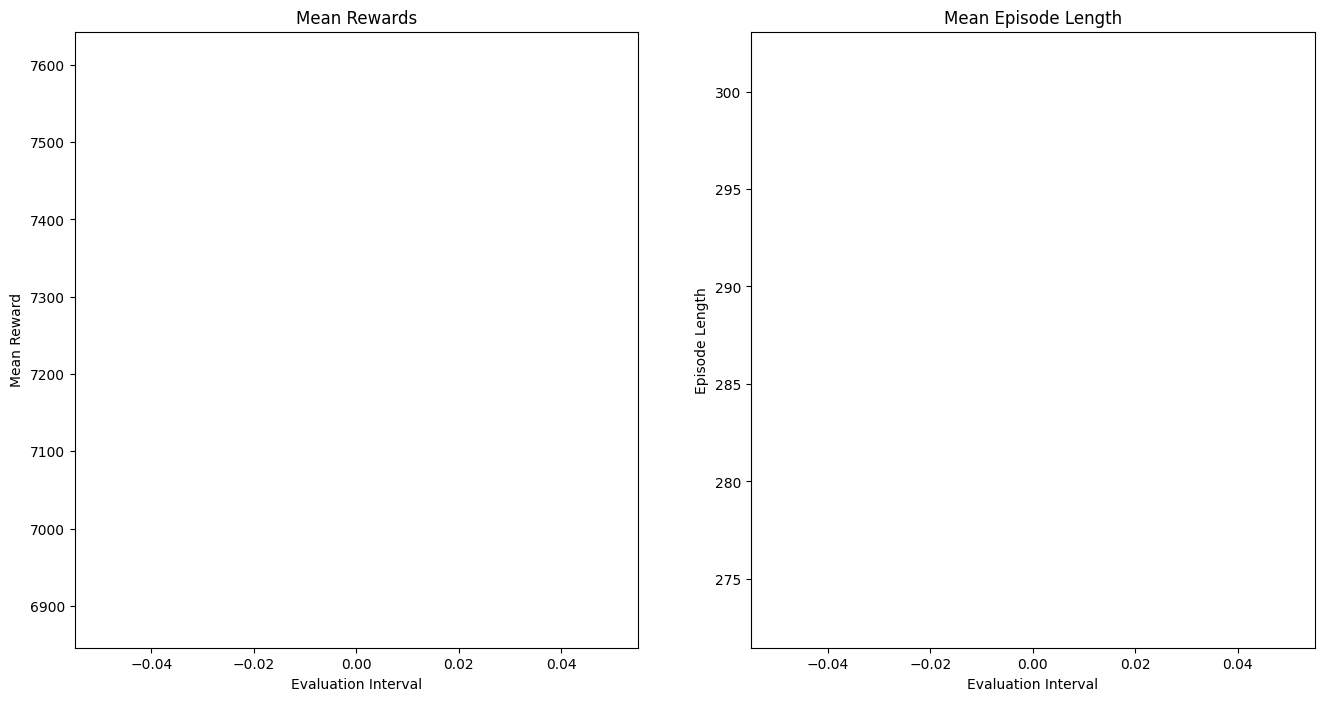

In [ ]:
import time

TRAINING_ITERATIONS = 9000
EVAL_INTERVAL = 50


# Modified training loop with better tracking
best_reward = float('-inf')
start_time = time.time()

for i in range(TRAINING_ITERATIONS):
    result = algo.train()
    
    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        current_reward = evaluation_results['env_runners']['episode_return_mean']
        rewards.append(current_reward)
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        
        # Save best model
        if current_reward > best_reward:
            best_reward = current_reward
            checkpoint_dir_sac = f"checkpoints/sac_best_reward"
            algo.save(checkpoint_dir_sac)
            
        # Print progress
        elapsed_time = (time.time() - start_time) / 3600  # in hours
        print(f"\nIteration {i+1}/{TRAINING_ITERATIONS}")
        print(f"Time elapsed: {elapsed_time:.2f} hours")
        print(f"Current reward: {current_reward:.2f}")
        print(f"Best reward so far: {best_reward:.2f}")
        
        plot_metrics(rewards, lengths)

### Save the weights:

In [ ]:
#policy = algo.get_policy()
# weights = algo.get_weights()

### Visualize how the algorithm performs:

In [ ]:
# For SAC
# For SAC: Ensure you load the best model
algo.restore(checkpoint_dir_sac)

env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="sac_last", episodes=3, max_steps=365)

GIF will be saved to: policy_gifs/auxiliary_loss_enhaded_policy.gif
Episode 1 finished with reward: -3690.00

Visualization interrupted by user
Visualization completed and resources cleaned up


## PPO

In [ ]:
from lunabot.geosearch import GeosearchEnv, Utils
import ray
from gymnasium.envs.registration import register
import gymnasium as gym
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.sac import SACConfig
from ray.rllib.algorithms.dqn import DQNConfig
import numpy as np
from ray import tune
import torch.nn.functional as F
from ray.rllib.algorithms.appo import APPOConfig
import matplotlib
import matplotlib.pyplot as plt
import torch
import pygame
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.torch_action_dist import TorchCategorical
import os
from ray.rllib.models import ModelCatalog
from ray.rllib.algorithms.callbacks import DefaultCallbacks
import numpy as np
import torch.nn as nn
# set up matplotlib interactive mode
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

register(
    id="GeosearchEnv-v0",
    entry_point="geosearch_package.geosearch:GeosearchEnv",
)
env = GeosearchEnv()
#env = gym.make("GeosearchEnv-v0")
obs, info = env.reset()
# print("Observation:", obs)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        
    def forward(self, x):
        return F.relu(x + self.conv(x))

class SkipConnection(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
        
    def forward(self, x):
        return x + self.module(x)

# -------------------------------------------------------------------
# EnhancedModelNoPlateau with optional auxiliary loss
# -------------------------------------------------------------------
class EnhancedModelNoPlateau(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name, **kwargs):
        nn.Module.__init__(self)
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        
        # Change the first convolution to expect 2 input channels:
        self.conv_net = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=5, padding=2),  # now 2 channels
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            
            # Adaptive pool to unify size => [B, 128, 4, 4]
            nn.AdaptiveAvgPool2d((4, 4)),
        )

        # 2) MLP for non-image features: ring_heights=25, battery=1, pos=2, sun=1, dust=1 => total=30
        self.mlp = nn.Sequential(
            nn.Linear(30, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            SkipConnection(nn.Linear(256, 256)),  # skip block
            nn.Linear(256, 128),
            nn.ReLU(inplace=True)
        )

        # Combined size: conv_net output (~2048) + mlp output (128) = 2176
        self.trunk = nn.Sequential(
        nn.Linear(2176, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        )


        # Final policy head for the environment's discrete actions
        self.policy_head = nn.Linear(256, num_outputs)

        # Optional value function head (used by RLlib)
        self.value_head = nn.Linear(256, 1)

        # Auxiliary head for water presence (predict 0/1)
        self.aux_head = nn.Linear(256, 1)

        # Store trunk outputs for use in value_function/forward_train
        self._shared_embedding = None

    def forward(self, input_dict, state, seq_lens):
        """
        Normal forward pass for RLlib. Returns policy logits.
        """
        obs = input_dict["obs"]

        # Process the water map (2-channel: water probabilities and agent mask)
        water_map = obs["water_map"].float()  # shape [B, 2, grid_height, grid_width]
        conv_feat = self.conv_net(water_map)   # shape [B, 128, 4, 4]
        conv_flat = conv_feat.view(conv_feat.size(0), -1)  # flatten to [B, 2048]

        # Process non-image features: ring_heights, battery, position, sunlight, dust (total 30 dims)
        non_image = torch.cat([
            obs["ring_heights"].float(),
            obs["battery"].float(),
            obs["position"].float(),
            obs["sunlight"].float(),
            obs["dust"].float()
        ], dim=1)  # shape [B, 30]
        mlp_out = self.mlp(non_image)  # shape [B, 128]

        # Combine the CNN features and non-image features
        combined_in = torch.cat([conv_flat, mlp_out], dim=1)  # shape [B, 2048+128=2176]
        trunk_out = self.trunk(combined_in)  # shape [B, 512]
        self._shared_embedding = trunk_out

        # Produce final policy logits
        logits = self.policy_head(trunk_out)  # shape [B, num_outputs]
        return logits, state

    def forward_train(self, input_dict, state, seq_lens):
        """
        Same as forward(), plus compute an auxiliary loss if "water_label" is present.
        """
        logits, state_out = self.forward(input_dict, state, seq_lens)

        if "water_label" in input_dict:
            label = input_dict["water_label"].float()  # shape [B] or [B, 1]
            p_pred = torch.sigmoid(self.aux_head(self._shared_embedding))  # shape [B, 1]
            if label.dim() == 1:
                label = label.unsqueeze(-1)
            aux_loss = F.binary_cross_entropy(p_pred, label)
            self._aux_loss = aux_loss
        else:
            self._aux_loss = torch.tensor(0.0, device=logits.device)

        return logits, state_out

    def loss(self, model_out, dist_class, train_batch):
        """
        Let RLlib compute its normal RL loss, then add our auxiliary loss.
        """
        base_loss = super().loss(model_out, dist_class, train_batch)
        return base_loss + 0.1 * self._aux_loss

    def value_function(self):
        """
        Used by some RLlib algorithms to get a V(s) or baseline.
        """
        if self._shared_embedding is None:
            return torch.zeros(1)
        return self.value_head(self._shared_embedding).squeeze(-1)

class WaterLabelCallback(DefaultCallbacks):
    def on_postprocess_trajectory(
        self,
        *,
        worker,
        episode,
        agent_id,
        policy_id,
        policies,
        postprocessed_batch,
        original_batches,
        **kwargs
    ):
        n = postprocessed_batch.count
        water_labels = np.zeros(shape=(n,), dtype=np.float32)

        # The env info at each step is in postprocessed_batch["infos"]
        if "infos" in postprocessed_batch:
            for i in range(n):
                info_i = postprocessed_batch["infos"][i]
                # Mark water_labels[i] = 1.0 if "is_water_here" was True
                if info_i is not None and info_i.get("is_water_here", False):
                    water_labels[i] = 1.0

        # Attach to the batch so your model can access it in forward_train()
        postprocessed_batch["water_label"] = water_labels

# def plot_metrics(rewards, lengths, aux_losses=None):
#     plt.figure(figsize=(18, 6))
    
#     # Reward and Length Plot
#     plt.subplot(1, 3, 1)
#     plt.plot(rewards, label='Mean Reward')
#     plt.plot(lengths, label='Mean Length')
#     plt.title('Training Progress')
#     plt.xlabel('Evaluation Interval')
#     plt.ylabel('Value')
#     plt.legend()
    
#     # Auxiliary Loss Plot
#     if aux_losses:
#         plt.subplot(1, 3, 2)
#         plt.plot(aux_losses)
#         plt.title('Auxiliary Loss')
#         plt.xlabel('Training Iteration')
#         plt.ylabel('Loss')
    
#     # Combined Metrics
#     plt.subplot(1, 3, 3)
#     plt.scatter(lengths, rewards, c=np.arange(len(rewards)), cmap='viridis')
#     plt.colorbar(label='Training Progress')
#     plt.title('Reward vs Episode Length')
#     plt.xlabel('Episode Length')
#     plt.ylabel('Episode Reward')
    
#     if is_ipython:
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
#     plt.tight_layout()

# Modified EnhancedModelNoPlateau class for PPO
class EnhancedPPOModel(EnhancedModelNoPlateau):
    def loss(self, model_out, dist_class, train_batch):
        # Calculate base PPO loss
        policy_loss = super().loss(model_out, dist_class, train_batch)
        
        # Value function loss
        vf_preds = model_out[SampleBatch.VF_PREDS]
        vf_targets = train_batch[SampleBatch.VF_PREDS]
        vf_loss = F.mse_loss(vf_preds, vf_targets)
        
        # Combine losses with auxiliary loss
        total_loss = policy_loss + 0.5 * vf_loss + 0.1 * self._aux_loss
        
        # Add KL divergence penalty
        if "kl" in train_batch:
            kl_coeff = self.config["kl_coeff"]
            total_loss += kl_coeff * train_batch["kl"]
            
        return total_loss

# Register the custom model
ModelCatalog.register_custom_model("custom_ppo_model", EnhancedPPOModel)

# Training Configuration
config = (
    PPOConfig()
    .environment(GeosearchEnv)
    .framework("torch")
    .callbacks(WaterLabelCallback)
    .training(
        model={
            "custom_model": "custom_ppo_model",
            "vf_share_layers": False,
            "fcnet_hiddens": [512, 512, 256],
        },
        lr=3e-4,
        clip_param=0.2,
        vf_clip_param=30,
        entropy_coeff=0.01,
        train_batch_size=512,  # Total batch size for training
        num_sgd_iter=10,       # Number of SGD iterations per batch
        lambda_=0.95,          # GAE lambda
        gamma=0.99,            # Discount factor
        kl_coeff=0.5,          # KL divergence coefficient
    )
    .rollouts(
        num_env_runners=4,     # Number of parallel workers
        rollout_fragment_length=64,  # Adjusted to match train_batch_size
        compress_observations=True,  # Compress observations to save memory
    )
    .evaluation(
        evaluation_num_workers=2,    # Number of evaluation workers
        evaluation_interval=50,     # Evaluate every 50 iterations
        evaluation_duration=30,     # Run evaluation for 30 episodes
    )
)

config.api_stack(
    enable_rl_module_and_learner=False,
    enable_env_runner_and_connector_v2=False
)

# Training Execution
algo = config.build()

/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment GeosearchEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
2025-02-13 23:23:32,761	WARNING deprecation.py:50 -- DeprecationWarning: `config.training(num_sgd_iter=..)` has been deprecated. Use `config.training(num_epochs=..)` instead. This will raise an error in the future!
2025-02-13 23:23:32,765	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2025-02-13 23:23:32,765	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation(evaluation_num_workers=..)` has been deprecated. Use `AlgorithmConfig.evaluation(evaluation_num_env_runners=..)` instead. This will raise an error in the future!
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/rllib/algor

KeyboardInterrupt: 

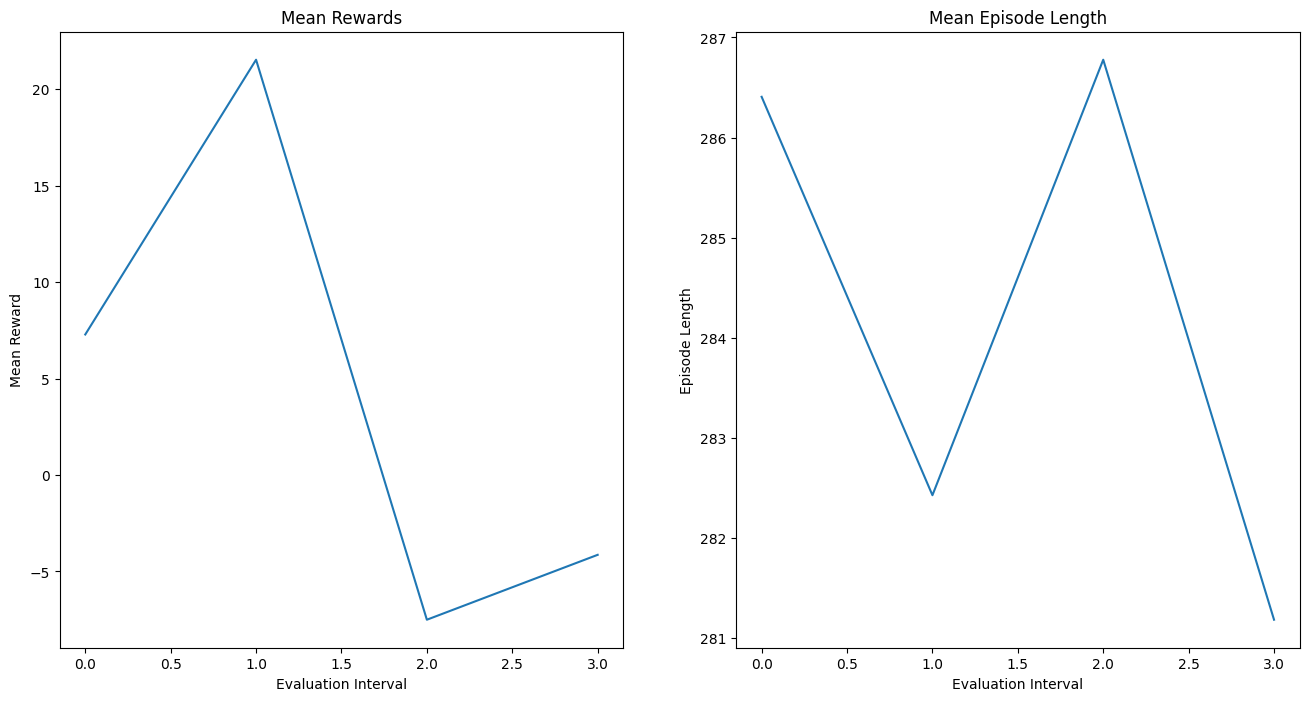

In [10]:
import time

TRAINING_ITERATIONS = 9000
EVAL_INTERVAL = 50

rewards = []
lengths = []

# Modified training loop with better tracking
best_reward = float('-inf')
start_time = time.time()

for i in range(TRAINING_ITERATIONS):
    result = algo.train()
    
    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        current_reward = evaluation_results['env_runners']['episode_return_mean']
        rewards.append(current_reward)
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        
        # Save best model
        if current_reward > best_reward:
            best_reward = current_reward
            checkpoint_dir_ppo = f"checkpoints/ppo_best_rewards"
            algo.save(checkpoint_dir_ppo)
            
        # Print progress
        elapsed_time = (time.time() - start_time) / 3600  # in hours
        print(f"\nIteration {i+1}/{TRAINING_ITERATIONS}")
        print(f"Time elapsed: {elapsed_time:.2f} hours")
        print(f"Current reward: {current_reward:.2f}")
        print(f"Best reward so far: {best_reward:.2f}")
        
        plot_metrics(rewards, lengths)

In [ ]:
# For PPo: Ensure you load the best model
algo.restore(checkpoint_dir_ppo)

env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="ppo_last", episodes=3, max_steps=365)

## DQN/Rainbow

### Ray Instance

In [19]:
config = DQNConfig()
config.framework_str = "torch"
config.env = GeosearchEnv
config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)
config.num_workers = 4
config.evaluation_interval = 50
config.evaluation_num_workers = 2
config.training(
    replay_buffer_config={
        "type": "MultiAgentReplayBuffer",
        "capacity": 10000,  # Adjust as needed
        # If you want prioritized replay:
        # "type": "MultiAgentPrioritizedReplayBuffer",
        # "prioritized_replay_alpha": 0.6,
        # "prioritized_replay_beta": 0.4,
        # "prioritized_replay_eps": 1e-6,
    }
)

algo = config.build()

2024-12-08 18:08:44,803	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
2024-12-08 18:08:47,447	WARNING util.py:61 -- Install gputil for GPU system monitoring.


### Training

In [20]:
rewards = []
lengths = []

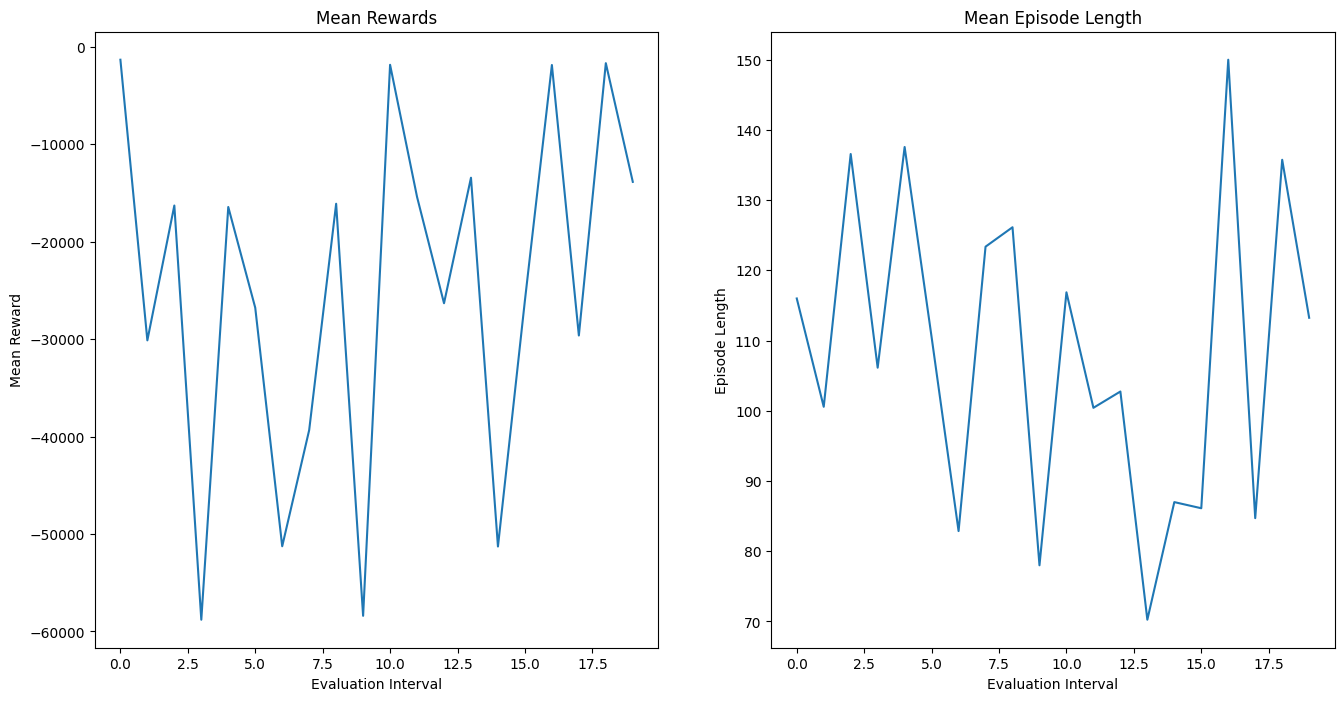

In [21]:
TRAINING_ITERATIONS = 1000
EVAL_INTERVAL = 50

for i in range(TRAINING_ITERATIONS):
    
    algo.train()

    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        rewards.append(evaluation_results['env_runners']['episode_return_mean'])
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        plot_metrics(rewards, lengths)
     

### Save the weights:

In [22]:
#policy = algo.get_policy()
weights = algo.get_weights()

### Visualize how the algorithm performs:

In [23]:
# For DQN
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="DQN", episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/dqn_policy.gif
Episode 1 finished with reward: -1230.00
Episode 2 finished with reward: -1265.00
Episode 3 finished with reward: -870.00
Gameplay GIF saved as policy_gifs/dqn_policy.gif
GIF saved successfully to policy_gifs/dqn_policy.gif
Average reward over 3 episodes: -1121.67
Visualization completed and resources cleaned up


## APPO

### Ray Instance and wrapping environment

In [24]:
# Initialize Ray
ray.init(ignore_reinit_error=True)

# Define the custom observation wrapper
class NoLimitObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        if isinstance(env.observation_space, gym.spaces.Dict):
            new_spaces = {}
            for key, space in env.observation_space.spaces.items():
                if isinstance(space, gym.spaces.Box):
                    shape = space.shape
                    new_spaces[key] = gym.spaces.Box(
                        low=-np.inf, high=np.inf, shape=shape, dtype=np.float32
                    )
                else:
                    # If there are other space types, handle them as needed
                    new_spaces[key] = space
            self.observation_space = gym.spaces.Dict(new_spaces)
        else:
            # If it's a single Box space
            shape = env.observation_space.shape
            self.observation_space = gym.spaces.Box(
                low=-np.inf, high=np.inf, shape=shape, dtype=np.float32
            )
    
    def observation(self, observation):
        return observation


# Define the environment creator function
def env_creator(env_config):
    env = GeosearchEnv()  # Directly instantiate the environment class
    env = NoLimitObservationWrapper(env)
    return env

# Register the custom environment
tune.register_env("NoLimitGeosearchEnv", env_creator)

# Configure APPO with the custom environment
config = APPOConfig()
config = config.environment(env="NoLimitGeosearchEnv", disable_env_checking=True)
config = config.framework("torch")
config = config.rollouts(num_env_runners=4)
config = config.evaluation(evaluation_num_workers=2, evaluation_interval=50)

# Build the algorithm
algo = config.build()


2024-12-08 20:29:55,293	INFO worker.py:1652 -- Calling ray.init() again after it has already been called.
2024-12-08 20:29:55,296	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-12-08 20:29:55,296	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation(evaluation_num_workers=..)` has been deprecated. Use `AlgorithmConfig.evaluation(evaluation_num_env_runners=..)` instead. This will raise an error in the future!
2024-12-08 20:30:00,435	WARNING util.py:61 -- Install gputil for GPU system monitoring.


### Training

In [25]:
rewards = []
lengths = []

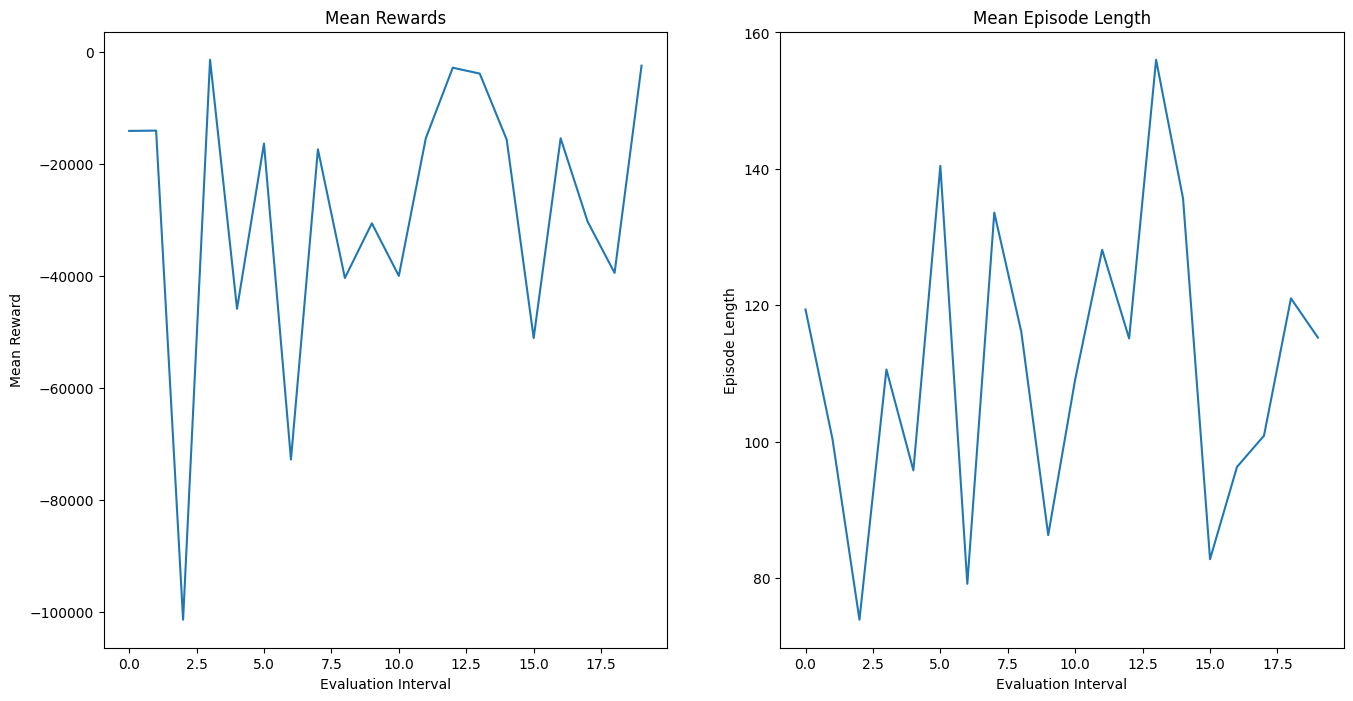

In [26]:
TRAINING_ITERATIONS = 1000
EVAL_INTERVAL = 50


for i in range(TRAINING_ITERATIONS):
    result = algo.train()
    
    # Access the mean episode reward and length from 'env_runners'
    mean_reward = result['env_runners']['episode_reward_mean']
    mean_length = result['env_runners']['episode_len_mean']
    
    print(f"Iteration {i+1}: episode_reward_mean = {mean_reward}, episode_len_mean = {mean_length}")

    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        eval_mean_reward = evaluation_results['env_runners']['episode_reward_mean']
        eval_mean_length = evaluation_results['env_runners']['episode_len_mean']
        rewards.append(eval_mean_reward)
        lengths.append(eval_mean_length)
        plot_metrics(rewards, lengths)

### Save the weights:

In [27]:
# For APPO
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="APPO", episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/appo_policy.gif
Episode 1 finished with reward: -2250.00
Episode 2 finished with reward: -1676.00
Episode 3 finished with reward: -1920.00
Gameplay GIF saved as policy_gifs/appo_policy.gif
GIF saved successfully to policy_gifs/appo_policy.gif
Average reward over 3 episodes: -1948.67
Visualization completed and resources cleaned up


### Visualize how the algorithm performs:

In [ ]:
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/algorithm_policy.gif
Episode 1 finished with reward: -2130.00
Episode 2 finished with reward: -2100.00


Exception in thread Thread-14:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 76, in run
    self.step()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 149, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 51, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty


Episode 3 finished with reward: -2820.00
Gameplay GIF saved as policy_gifs/algorithm_policy.gif
GIF saved successfully to policy_gifs/algorithm_policy.gif
Average reward over 3 episodes: -2350.00
Visualization completed and resources cleaned up


: 